# (Simulation) Earthquake
> Example 1

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [논문연구]

#### 5.1.1 SPECTRAL NETWORK

$$g_{\theta} \star x = U g_{\theta}(\Lambda) U^{\top}x$$

$x$는 실수($n \times 1$ or $1 \times n$), $g_{\theta}$는 $\theta$의 대각행렬, $\theta$는 실수($n \times 1$ or $1 \times n$)

$U$가 정규화된 그래프 라플라시안의 고유벡터 행렬일떄($L = I_N - D^{-\frac{1}{2}}AD^{-\frac{1}{2}} = U\Lambda U^{\top}$), 고유값 $\Lambda$의 대각 행렬을 가진다.

Bruna가 재안한 operation에서 Henaff 는 평활 계수를 가진 파라미터로 차원적이며 집약적인 spectral filters 를 만듦

---

Beuna

---

Henaff

$W$가 $n \times n$  대칭 행렬

$L = I_N - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$

$D_{ij} = \sum_{ij}W_{ij}$

$U = (u_1, \dots, u_N)$

$X = \mathbb{R}^N$

$x *_Gg = U^{\top} (U_x \odot U)g)$

$\odot$: a point-wise product

$w_g = (w_1, \dots, w_N)$

$x *_Gg := U^{\top} (diag(w_g)U_x)$

$\big{|} \frac{\partial^k \hat{x} (\xi)}{\partial \xi^k} \big{|} \le \int |u|^k |x(u)|\: \mathrm{d}x $

$\hat{x} (\xi)$ is the Fourier tranform of $x$

$w_g = \mathcal{K}\tilde{w}_g$

$\mathcal{K}$ is a smoothing kernal, $\mathcal{K} \in \mathbb{R}^{N \times N_0}$

forward, backward 가능

unsupervised graph estimation 
- $d(i,j) = \|X_i - X_j \|^2
- $w(i,j) = exp^{\frac{d(i,j)}{\sigma^2}}$$

supervised graph estimation
- a fully-connected network
- $d_{sup}(i,j) = \| W_{1,i} - W_{1,j} \|^2$

---

#### 5.1.2 CHEBNET

$$g_{\theta} \star x \approx  \sum^{K}_{k=0}\theta_k T_k (\tilde{L})x$$

 The Chebyshev polynomials 체비셰프 다항식

$\tilde{L} = \cfrac{2}{\lambda_{max}} L - I_N$

$\lambda_{max}$는 라플라시안 고유값들 중 가장 큰 값

$T_k (x) = 2xT_{k-1}(x) - T_{k-2} (x)$

$T_0 (x) = 1$, $T_1(x) = x$

## imports

In [1]:
import rpy2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [3]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

## EbayesThresh

In [4]:
%load_ext rpy2.ipython

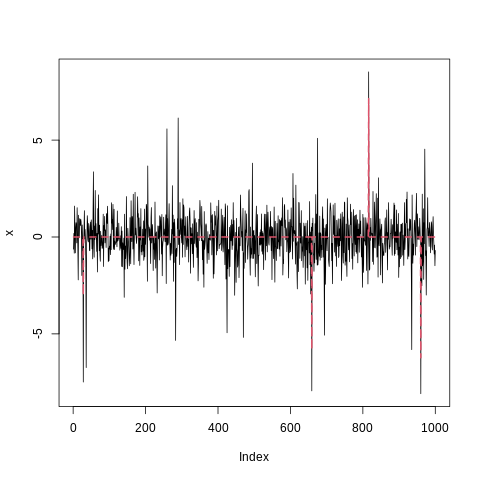

In [5]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
plot(x,type='l')
mu <- EbayesThresh::ebayesthresh(x,sdev=2)
lines(mu,col=2,lty=2,lwd=2)

### R + python

`-` R환경에 있던 x를 가지고 오기

In [6]:
%R -o x 

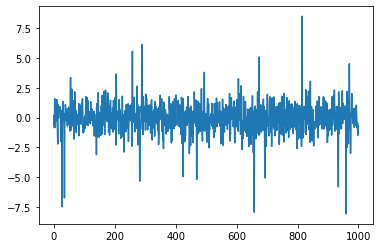

In [7]:
plt.plot(x)

`-` R환경에 있는 ebayesthresh 함수를 가지고 오기

In [8]:
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [9]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [10]:
xhat = np.array(ebayesthresh(FloatVector(x)))

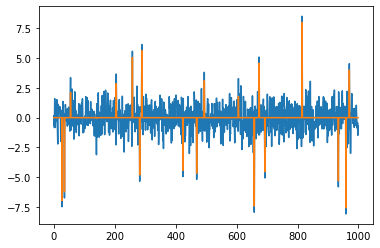

In [11]:
plt.plot(x)
plt.plot(xhat)

## 시도 1

In [12]:
_x = np.linspace(0,2,1000)
_y = 5*_x  + x # x is epsilon

In [13]:
df1=pd.DataFrame({'x':_x, 'y':_y})

In [14]:
w=np.zeros((1000,1000))

In [15]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [16]:
class SIMUL:
    def __init__(self,df1):
        self.df = df1 
        self.y = df1.y.to_numpy()
        self.x = df1.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        self.differ3=(np.abs(self.y-self.yhat)-np.min(np.abs(self.y-self.yhat)))/(np.max(np.abs(self.y-self.yhat))-np.min(np.abs(self.y-self.yhat))) #color 표현은 위핸 표준화
        with plt.style.context('seaborn-dark'):
            plt.figure(figsize=(16,10))
            plt.scatter(self.x,self.y,c=self.differ3,cmap='Purples',s=50)
            plt.plot(self.x,self.yhat, 'k--')

In [17]:
_simul = SIMUL(df1)

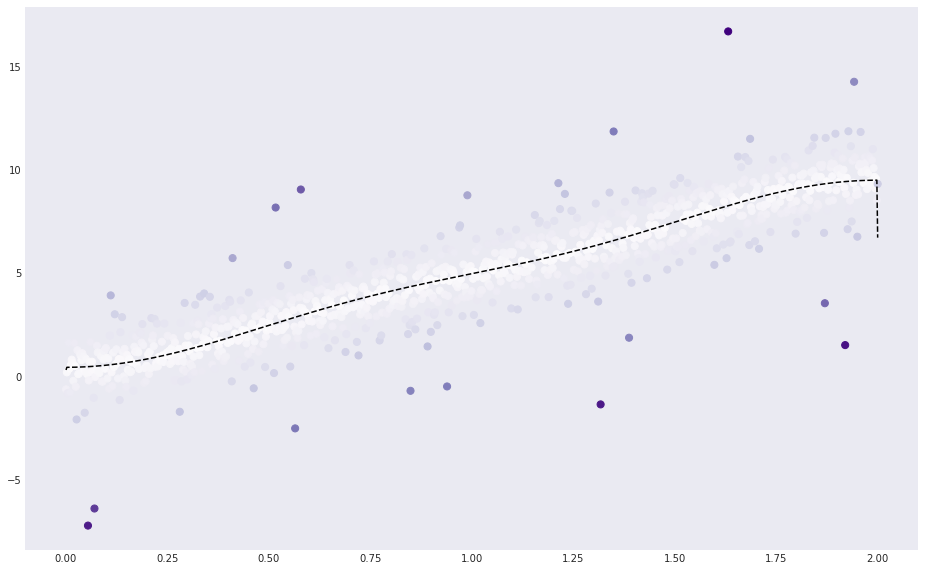

In [18]:
_simul.fit2()

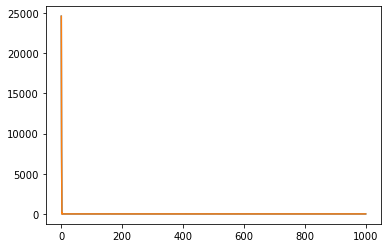

In [19]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

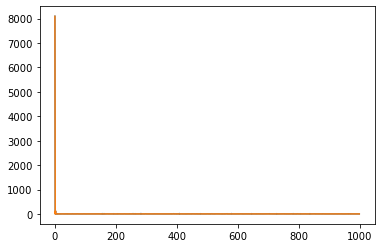

In [20]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

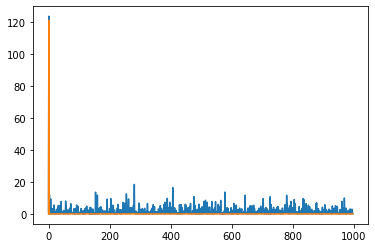

In [21]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [22]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.309371,-0.935825
1,0.002002,0.193653,0.437559,-0.243905
2,0.004004,-0.815609,0.437685,-1.253293
3,0.006006,1.625311,0.437895,1.187416
4,0.008008,0.369548,0.438189,-0.068642
...,...,...,...,...
995,1.991992,9.646667,9.485113,0.161554
996,1.993994,9.089299,9.485407,-0.396108
997,1.995996,9.560693,9.485618,0.075076
998,1.997998,8.507238,9.485744,-0.978505


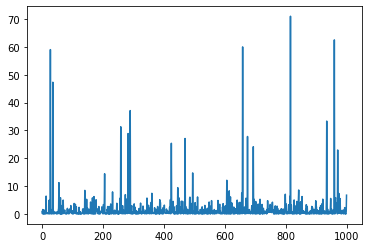

In [23]:
plt.plot((_simul.df.Residual)**2)

## 시도 2

In [24]:
_x = np.linspace(0,2,1000)
_y = 5*_x**2  + x # x is epsilon

In [25]:
df2=pd.DataFrame({'x':_x, 'y':_y})

In [26]:
_simul = SIMUL(df2)

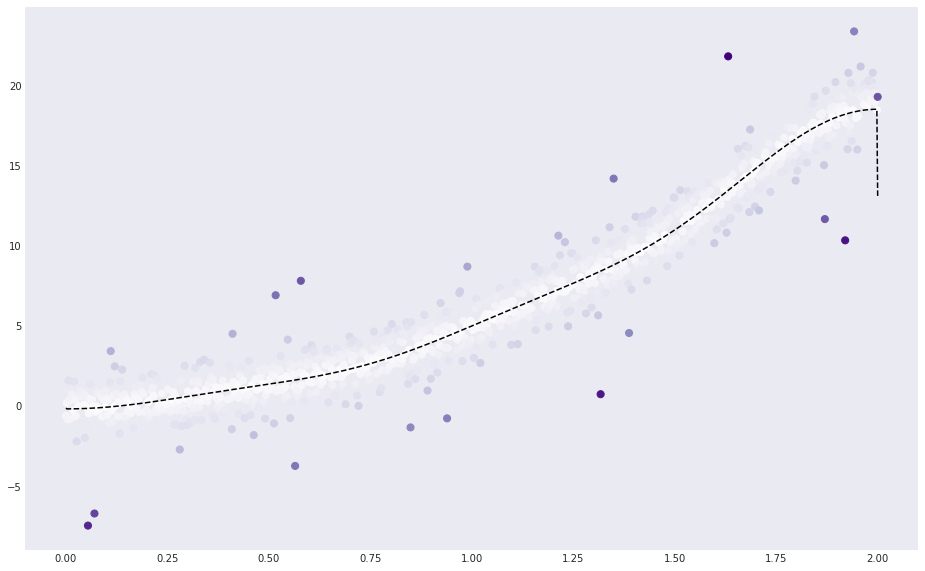

In [27]:
_simul.fit2(sd=6)

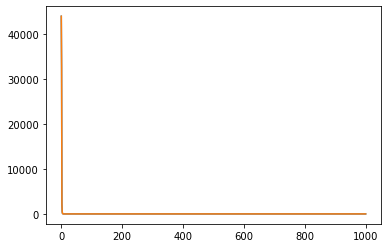

In [28]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

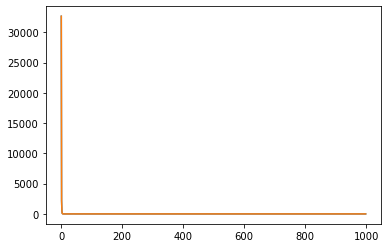

In [29]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

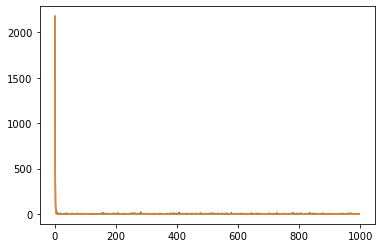

In [30]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [31]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,-0.130221,-0.496233
1,0.002002,0.183663,-0.184116,0.367779
2,0.004004,-0.835548,-0.183981,-0.651567
3,0.006006,1.595461,-0.183757,1.779218
4,0.008008,0.329828,-0.183443,0.513271
...,...,...,...,...
995,1.991992,19.526868,18.527034,0.999834
996,1.993994,18.999390,18.528429,0.470961
997,1.995996,19.500713,18.529425,0.971288
998,1.997998,18.477228,18.530023,-0.052795


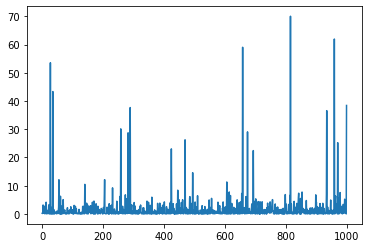

In [32]:
plt.plot((_simul.df.Residual)**2)

## 시도 3

In [33]:
_x = np.linspace(0,2,1000)
_y = 5*_x**3  + x # x is epsilon

In [34]:
df3=pd.DataFrame({'x':_x, 'y':_y})

In [35]:
_simul = SIMUL(df3)

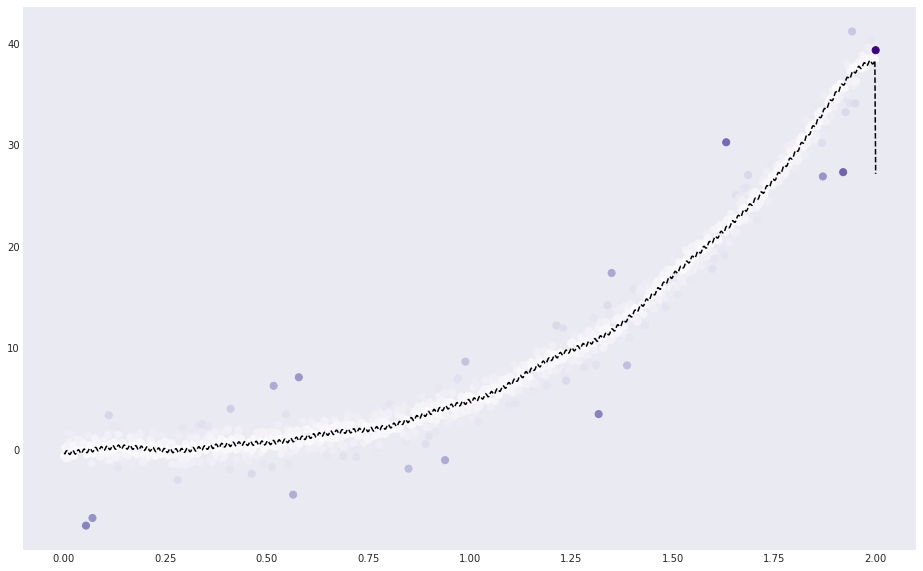

In [36]:
_simul.fit2()

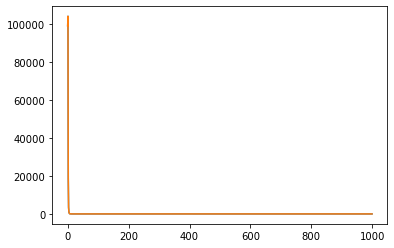

In [37]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

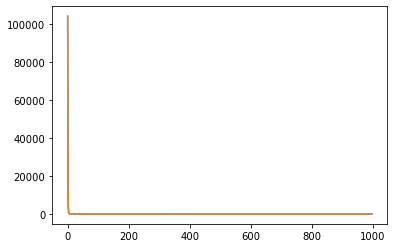

In [38]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

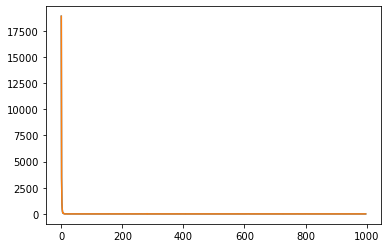

In [39]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [40]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,-0.355221,-0.271233
1,0.002002,0.183643,-0.426159,0.609802
2,0.004004,-0.835628,-0.253840,-0.581789
3,0.006006,1.595282,-0.112524,1.707806
4,0.008008,0.329510,-0.105971,0.435481
...,...,...,...,...
995,1.991992,39.208148,37.949381,1.258767
996,1.993994,38.760050,37.964600,0.795450
997,1.995996,39.340954,38.112109,1.228845
998,1.997998,38.397248,38.288145,0.109103


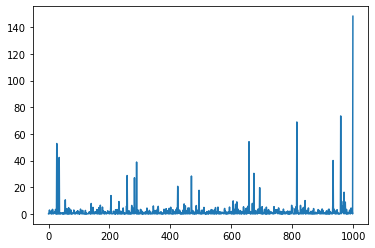

In [41]:
plt.plot((_simul.df.Residual)**2)

## 시도 4

In [42]:
_x = np.linspace(0,2,1000)
_y = 5*np.sin(_x)  + x # x is epsilon

In [43]:
df4=pd.DataFrame({'x':_x, 'y':_y})

In [44]:
_simul = SIMUL(df4)

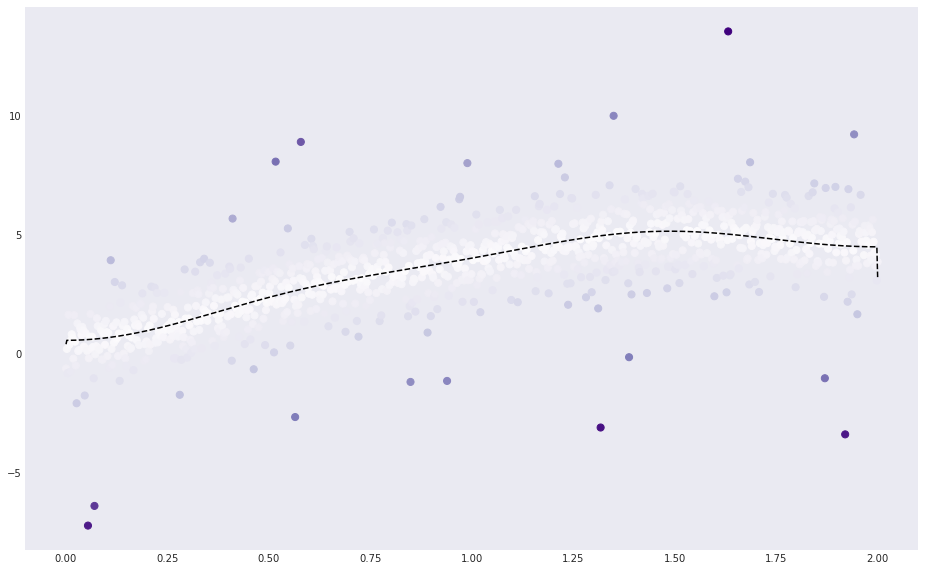

In [45]:
_simul.fit2()

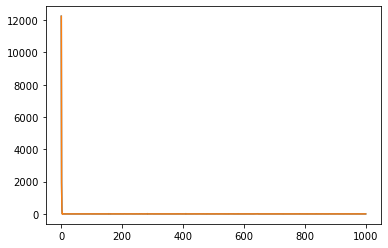

In [46]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

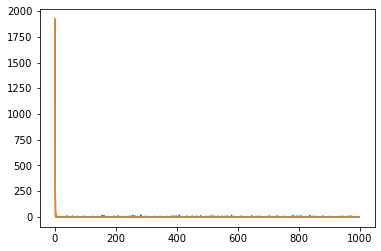

In [47]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

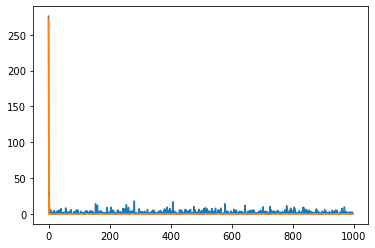

In [48]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [49]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.392042,-1.018496
1,0.002002,0.193653,0.554474,-0.360821
2,0.004004,-0.815609,0.554605,-1.370214
3,0.006006,1.625311,0.554823,1.070488
4,0.008008,0.369547,0.555128,-0.185581
...,...,...,...,...
995,1.991992,4.249711,4.476612,-0.226901
996,1.993994,3.678231,4.476443,-0.798212
997,1.995996,4.135495,4.476322,-0.340827
998,1.997998,3.067892,4.476249,-1.408357


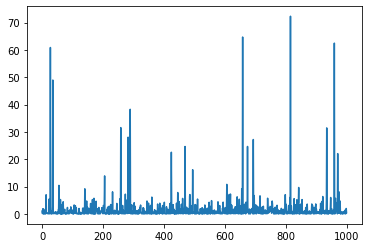

In [50]:
plt.plot((_simul.df.Residual)**2)

## 시도 5

In [51]:
_x = np.linspace(0,2,1000)
_y =  3*np.cos(_x) + 1*np.cos(_x**2) + 0.5*np.cos(5*_x)  + x # x is epsilon

In [52]:
df5=pd.DataFrame({'x':_x, 'y':_y})

In [53]:
_simul = SIMUL(df5)

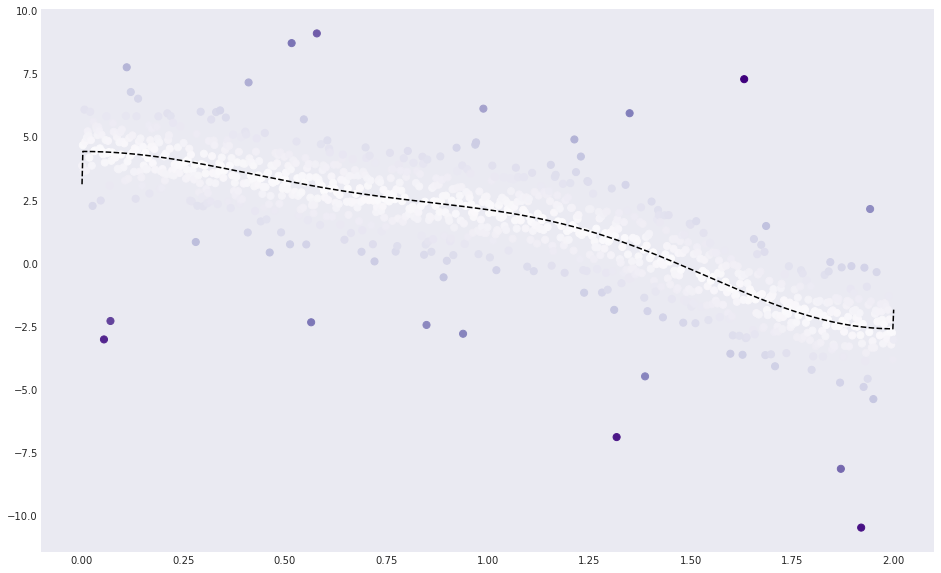

In [54]:
_simul.fit2()

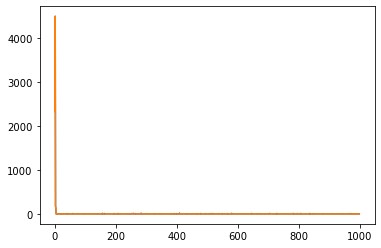

In [55]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

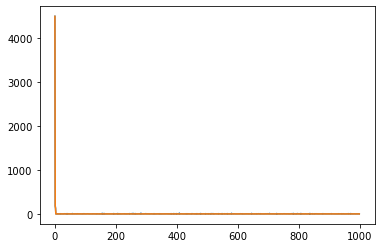

In [56]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

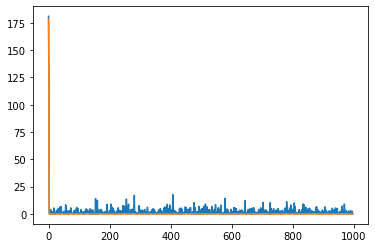

In [57]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [58]:
_simul.df

,x,y,yHat,Residual
0,0.000000,3.873546,3.138285,0.735261
1,0.002002,4.683612,4.438180,0.245433
2,0.004004,3.664247,4.438102,-0.773855
3,0.006006,6.095001,4.437973,1.657028
4,0.008008,4.829011,4.437793,0.391218
...,...,...,...,...
995,1.991992,-2.647435,-2.586586,-0.060849
996,1.993994,-3.211827,-2.586934,-0.624893
997,1.995996,-2.747360,-2.587182,-0.160178
998,1.997998,-3.807646,-2.587331,-1.220315


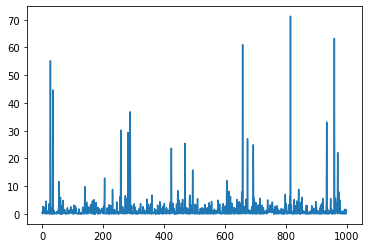

In [59]:
plt.plot((_simul.df.Residual)**2)

---